# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [15]:
from typing import Tuple, Callable

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    Resize
)

import tests

In [16]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [17]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """
    Transforms to apply to the image.
    Args:
        size: Target size of the images
    Returns:
        Composition of transforms
    """
    transforms = [
        Resize(size),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [18]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import os
from typing import Callable


class DatasetDirectory(Dataset):
    """A PyTorch Dataset class for loading images from a directory.
    
    Args:
        directory (str): Path to directory containing image files
        transforms (Callable, optional): Transformations to apply to images. Defaults to basic 64x64 transforms.
        extension (str, optional): File extension to filter by. Defaults to '.jpg'.
    
    Attributes:
        directory (str): Directory containing images
        image_files (list): Sorted list of image file paths
        transforms (Callable): Image transformation function
    
    Methods:
        __len__(): Returns number of images in dataset
        __getitem__(index): Returns transformed image tensor at given index
    
    Example:
        >>> dataset = DatasetDirectory('path/to/images')
        >>> len(dataset)  # Number of images
        100
        >>> image = dataset[0]  # First image tensor
    """
    def __init__(self, directory: str, transforms: Callable = None, extension: str = '.jpg'):
        """Initialize dataset with directory of images."""
        self.directory = directory
        self.image_files = sorted([
            os.path.join(directory, f)
            for f in os.listdir(directory)
            if f.endswith(extension)
        ])

        # Default transform if none provided
        self.transforms = transforms if transforms else get_transforms((64, 64))

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """Get a single image."""
        # Get image path
        image_path = self.image_files[index]

        # Load and convert image to RGB
        image = Image.open(image_path).convert('RGB')

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)

        return image

In [19]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

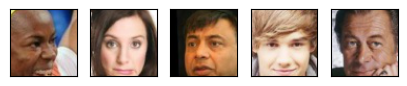

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8.
        Convert normalized image tensors back to displayable uint8 format.
    
    Args:
        images (numpy.ndarray): Image array in range [-1.0, 1.0]
    
    Returns:
        numpy.ndarray: Image array in range [0, 255] as uint8
    
    Example:
        >>> normalized = np.random.uniform(-1, 1, (3, 64, 64))
        >>> display_ready = denormalize(normalized)  # (64, 64, 3) uint8 array
    """
    return ((images + 1.) / 2. * 255).astype(np.uint8)


# Visualization code documentation:
"""
Visualizes a batch of images from the dataset.

Creates a 2-row grid of images with:
- 20 total subplots (10 per row) 
- No axis ticks
- Each image is:
  1. Converted to numpy array
  2. Transposed from (C,H,W) to (H,W,C) 
  3. Denormalized from [-1,1] to [0,255]
  4. Displayed using matplotlib

# Common PyTorch image tensor dimensions:
W = Width    # Image width in pixels
H = Height   # Image height in pixels  
C = Channel  # Color channels (3 for RGB, 1 for grayscale)

# Typical shape orders:
# PyTorch: (C, H, W) - Channels first
# NumPy/matplotlib: (H, W, C) - Channels last

Parameters:
- figsize: Tuple controlling figure dimensions (20,4) inches
- plot_size: Number of images to display (20)
- dataset: PyTorch dataset containing normalized images

plot the images in the batch, along with the corresponding labels
"""

fig = plt.figure(figsize=(5, 1))
plot_size = 5

for idx in np.arange(plot_size):
    ax = fig.add_subplot(1, plot_size, idx + 1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [22]:
from torch.nn import Module
import torch
import torch.nn as nn

#### Generative Adversarial Networks: The Discriminator

##### The Discriminator Component in GANs

The discriminator in a Generative Adversarial Network (GAN) functions as a binary classifier that distinguishes between real data samples and synthetic samples produced by the generator. This critical component provides the learning signal that drives the generator's improvement through adversarial training.

##### Theoretical Foundation of the Discriminator

In the GAN framework, introduced by Goodfellow et al. (2014), the discriminator (D) and generator (G) engage in a minimax game defined by the following objective function:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

Where:
- $D(x)$ represents the discriminator's estimate of the probability that real data $x$ is real
- $G(z)$ is the generator's output when given noise $z$
- $p_{data}$ is the real data distribution
- $p_z$ is the noise distribution (typically uniform or Gaussian)

The discriminator aims to maximize this function, which means:
- Maximizing $\log D(x)$ for real samples (correctly identifying real as real)
- Maximizing $\log(1-D(G(z)))$ for fake samples (correctly identifying fake as fake)

##### DCGAN Discriminator Architecture

The provided code implements a Deep Convolutional GAN (DCGAN) discriminator, following design principles from Radford et al. (2015). Let's analyze the actual implementation:

```mermaid
flowchart TD
    Input["Input: RGB Image<br>3×64×64"] --> Conv1["Conv1: 3→64 channels<br>4×4 kernel, stride=2<br>64×32×32"]
    Conv1 --> LeakyReLU1["LeakyReLU<br>α=0.2"]
    LeakyReLU1 --> Conv2["Conv2: 64→128 channels<br>4×4 kernel, stride=2<br>128×16×16"]
    Conv2 --> BatchNorm2["Batch Normalization"]
    BatchNorm2 --> LeakyReLU2["LeakyReLU<br>α=0.2"]
    LeakyReLU2 --> Conv3["Conv3: 128→256 channels<br>4×4 kernel, stride=2<br>256×8×8"]
    Conv3 --> BatchNorm3["Batch Normalization"]
    BatchNorm3 --> LeakyReLU3["LeakyReLU<br>α=0.2"]
    LeakyReLU3 --> Conv4["Conv4: 256→512 channels<br>4×4 kernel, stride=2<br>512×4×4"]
    Conv4 --> BatchNorm4["Batch Normalization"]
    BatchNorm4 --> LeakyReLU4["LeakyReLU<br>α=0.2"]
    LeakyReLU4 --> Conv5["Conv5: 512→1 channel<br>4×4 kernel, stride=1<br>1×1×1"]
    Conv5 --> Sigmoid["Sigmoid Activation"]
    Sigmoid --> Output["Output: Probability<br>Real vs. Fake"]
    
    style Input fill:#BCFB89
    style Conv1 fill:#9AE4F5
    style Conv2 fill:#9AE4F5
    style Conv3 fill:#9AE4F5
    style Conv4 fill:#9AE4F5
    style Conv5 fill:#9AE4F5
    style LeakyReLU1 fill:#FBF266
    style LeakyReLU2 fill:#FBF266
    style LeakyReLU3 fill:#FBF266
    style LeakyReLU4 fill:#FBF266
    style BatchNorm2 fill:#FA756A
    style BatchNorm3 fill:#FA756A
    style BatchNorm4 fill:#FA756A
    style Sigmoid fill:#0096D9
    style Output fill:#FCEB14
```

##### Detailed Architecture Analysis

Examining the provided implementation reveals several key architectural decisions:

1. **Convolutional Layers with Precise Parameterization**:
   - All convolutional layers use 4×4 kernels, which is a standard choice in DCGAN
   - First layer: $3 \rightarrow 64$ channels (RGB input to first feature set)
   - Progressive channel doubling: $64 \rightarrow 128 \rightarrow 256 \rightarrow 512$
   - Final layer: $512 \rightarrow 1$ (single output for binary classification)

2. **Downsampling Strategy**:
   - Stride=2 for spatial downsampling in the first four layers (halving dimensions each time)
   - Stride=1 in the final layer to reach 1×1 spatial dimensions

   The spatial dimension progression follows:
   $$64 \times 64 \rightarrow 32 \times 32 \rightarrow 16 \times 16 \rightarrow 8 \times 8 \rightarrow 4 \times 4 \rightarrow 1 \times 1$$

3. **Activation Functions**:
   - LeakyReLU with negative slope 0.2 for all intermediate layers
   - Sigmoid activation for the final layer, constraining output to [0,1]

4. **Normalization**:
   - BatchNorm2d applied after each convolutional layer except the first and last
   - First layer omits BatchNorm to allow the model to learn from the input distribution
   - Final layer omits BatchNorm to avoid constraining the output distribution

5. **Bias Parameter**:
   - All convolutional layers set `bias=False` when batch normalization follows
   - This reduces redundant parameters as the BatchNorm already includes a learnable bias

##### Implementation Details

The code reveals several important implementation techniques:

```python
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # DCGAN-style discriminator
        self.main = nn.Sequential(
            # Input: 3x64x64
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64x32x32
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128x16x16
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256x8x8
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512x4x4 -> 1x1x1x1
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
```

Notable aspects include:

1. **Sequential Container**: Using `nn.Sequential` for clean, compact layer organization

2. **Padding Strategy**:
   - `padding=1` in the first four layers maintains appropriate spatial dimensions
   - `padding=0` in the final layer ensures reduction to 1×1 output

3. **inplace=True** for LeakyReLU:
   - Modifies input directly rather than creating a new tensor
   - Improves memory efficiency during training

##### The Forward Pass

The `forward` method processes input through the network:

```python
def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass for discriminator.
    
    Args:
        x: Input tensor of shape (N, C, H, W)
        
    Returns:
        torch.Tensor: Probability scores of shape (N, 1)
    """
    return self.main(x).view(-1, 1, 1, 1)
```

This method:
1. Passes the input tensor through the sequential layers
2. Reshapes the output using `.view(-1, 1, 1, 1)` to maintain a 4D tensor structure
   - This is an interesting choice as most implementations would use `.view(-1, 1)` for a batch of scalar outputs
   - The additional dimensions might be used for compatibility with specific loss functions or architectures

##### Mathematical Analysis of the Discriminator's Operation

For an input image $x \in \mathbb{R}^{3 \times 64 \times 64}$, the forward pass can be expressed as:

1. First layer: $h_1 = \text{LeakyReLU}(\text{Conv2D}(x))$
2. Intermediate layers: $h_{i+1} = \text{LeakyReLU}(\text{BatchNorm}(\text{Conv2D}(h_i)))$ for $i \in \{1, 2, 3\}$
3. Final layer: $y = \sigma(\text{Conv2D}(h_4))$

Where $\sigma$ is the sigmoid function:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

##### Training Dynamics and Optimization

During training, the discriminator is optimized to maximize:

$$\max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

In practice, this translates to minimizing the binary cross-entropy loss:

$$\mathcal{L}_D = -\frac{1}{m} \sum_{i=1}^{m} [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]$$

Where:
- $m$ is the batch size
- $x^{(i)}$ are real data samples
- $z^{(i)}$ are noise samples

##### Advanced Training Techniques

While the architecture above represents the standard DCGAN discriminator, several techniques can enhance training stability:

1. **Label Smoothing**: Using targets of 0.9 instead of 1.0 for real samples:
   ```python
   real_labels = torch.full((batch_size,), 0.9, device=device)
   ```

2. **Noise Injection**: Adding small Gaussian noise to inputs:
   ```python
   real_images += 0.05 * torch.randn_like(real_images)
   ```

3. **One-sided Label Smoothing**: Only smoothing the real labels (not fake ones)

4. **Feature Matching**: Using intermediate features for additional loss terms

##### Spectral Normalization Enhancement

A common enhancement to the discriminator is spectral normalization, which constrains the Lipschitz constant of each layer:

```python
# Modified layer with spectral normalization
nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)),
```

This technique stabilizes training by preventing extreme gradients and mode collapse.

##### Conclusion

The DCGAN discriminator architecture presented in the code exemplifies a well-structured convolutional network designed for binary classification of images. It incorporates key principles that have made DCGANs successful:

1. Progressive downsampling using strided convolutions
2. Gradually increasing feature channels
3. LeakyReLU activations for better gradient flow
4. Batch normalization for training stability
5. Full convolutional architecture without fully connected layers

This architecture has served as a foundation for numerous GAN variants and continues to be relevant in modern generative modeling. The discriminator's ability to learn a complex decision boundary in high-dimensional space is what enables the generator to produce increasingly realistic outputs through adversarial training.

---
#### DCGAN-style discriminator network for image classification.

##### Architecture Overview

- Input: (N, 3, 64, 64) tensor (batch of 64x64 RGB images)
- Output: (N, 1) tensor (probability scores ∈ [0,1])
- Key Components:
- 4 convolutional layers with LeakyReLU(0.2)
- Batch normalization (except input layer)
- Strided convolutions (downsampling)
- Sigmoid activation for binary classification

The notation 3x64x64 refers to the input tensor dimensions, while the numbers in Conv2d(3, 64, 4,...) are the layer parameters. Here's the breakdown:

Input Dimensions (3x64x64):
- 3: Channels (RGB)
- 64: Height (pixels)
- 64: Width (pixels)

Conv2d Parameters (3, 64, 4):
- in_channels=3: Matches the input's 3 RGB channels.
- out_channels=64: Creates 64 output feature maps. So we need to use 64 filters/ kernels for 64 output feature maps.
- kernel_size=4: Uses a 4x4 convolutional filter.

How Dimensions Transform:
- Input: (batch_size, 3, 64, 64)
- After Conv2d:
  - Spatial size: (64 - 4 + 2*1)/2 + 1 = 32 (due to stride=2, padding=1)
  - Output: (batch_size, 64, 32, 32)

Key Formula:

output_size = (input_size - kernel_size + 2*padding)/stride + 1
= (H - F + 2P)/S + 1

##### Layer-by-Layer Breakdown

1. Input Layer
   - Shape: `3x64x64` (RGB image)
   - Conv2d: `3 → 64` channels, kernel=4x4, stride=2, padding=1
   - Effect: Halves spatial dimensions → `64x32x32`
   - LeakyReLU: Negative slope=0.2 (preserves gradient flow)

2. Hidden Layer 1
   - Shape: `64x32x32`
   - Conv2d: `64 → 128` channels, kernel=4x4, stride=2, padding=1
   - BatchNorm2d: Normalizes 128-channel output
   - LeakyReLU: Same as above → `128x16x16`

3. Hidden Layer 2
   - Shape: `128x16x16`
   - Conv2d: `128 → 256` channels, kernel=4x4, stride=2, padding=1
   - BatchNorm2d: Normalizes 256-channel output
   - LeakyReLU → `256x8x8`

4. Hidden Layer 3
   - Shape: `256x8x8`
   - Conv2d: `256 → 512` channels, kernel=4x4, stride=2, padding=1
   - BatchNorm2d: Normalizes 512-channel output
   - LeakyReLU → `512x4x4`

5. Output Layer
   - Conv2d: `512 → 1` channel, kernel=4x4, stride=1, padding=0
   - Sigmoid: Maps to probability ∈ [0,1] → `1x1x1`

##### Dimensionality Progression

```python
3x64x64 → 64x32x32 → 128x16x16 → 256x8x8 → 512x4x4 → 1x1x1   
```

##### Usage Example

```python
D = Discriminator()
images = torch.randn(32, 3, 64, 64)  # Batch of 32 fake images
outputs = D(images)  # Shape: (32, 1)
``` 

##### Why This Architecture Works
- Strided Convs: Efficient downsampling without pooling
- BatchNorm: Stabilizes training in deep networks
- LeakyReLU: Prevents "dead neurons" in discriminator
- No Bias: BatchNorm makes bias redundant
- Sigmoid: Classic choice for binary classification


In [23]:
class Discriminator(Module):
    """DCGAN-style discriminator network for image classification.
    
    Architecture:
    - 4 convolutional layers with LeakyReLU activation
    - Batch normalization in intermediate layers  
    - Strided convolutions for downsampling
    - Final sigmoid activation for binary classification
    
    Input: (N, 3, 64, 64) tensor (batch of 64x64 RGB images)
    Output: (N, 1) tensor (probability of being real)
    
    Dimensionality progression:
    3x64x64 → 64x32x32 → 128x16x16 → 256x8x8 → 512x4x4 → 1x1x1
    
    Args:
        None (fixed architecture)
    
    Methods:
        forward(x): Processes input tensor through the network
    
    Example:
        >>> D = Discriminator()
        >>> images = torch.randn(32, 3, 64, 64)  # Batch of 32 fake images
        >>> outputs = D(images)  # Shape: (32, 1)

        ##### Shape Transformation Diagram

        Input Image:    [N, 3, 64, 64]  # Batch × RGB × Height × Width
        │
        ▼
        Layer 1 Conv:   [N, 64, 32, 32]  # (64-4+2)/2 + 1 = 32
        │
        ▼
        Layer 2 Conv:   [N, 128, 16, 16]  # (32-4+2)/2 + 1 = 16
        │
        ▼  
        Layer 3 Conv:   [N, 256, 8, 8]    # (16-4+2)/2 + 1 = 8
        │
        ▼
        Layer 4 Conv:   [N, 512, 4, 4]    # (8-4+2)/2 + 1 = 4
        │
        ▼
        Output Conv:    [N, 1, 1, 1]      # (4-4+0)/1 + 1 = 1


        [3,64,64]              [64,32,32]             [128,16,16]
        ┌───────┐              ┌────────┐             ┌─────────┐
        │ RGB   │              │ 64 fm  │             │ 128 fm  │
        │ Input │──Conv2d─────▶│ 32×32  │──Conv2d────▶│ 16×16   │
        └───────┘              └────────┘             └─────────┘
                                        
        [256,8,8]              [512,4,4]               [1,1,1]
        ┌────────┐             ┌───────┐               ┌─────┐
        │ 256 fm │             │512 fm │               │Score│
        │  8×8   │──Conv2d────▶│ 4×4   │──Conv2d──────▶│ 1×1 │
        └────────┘             └───────┘               └─────┘

    """

    def __init__(self):
        """Initializes discriminator layers with DCGAN architecture."""
        super(Discriminator, self).__init__()

        # DCGAN-style discriminator
        self.main = nn.Sequential(
            # Input: 3x64x64
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64x32x32
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128x16x16
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256x8x8
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512x4x4 -> 1x1x1x1
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass for discriminator.
        
        Args:
            x: Input tensor of shape (N, C, H, W)
            
        Returns:
            torch.Tensor: Probability scores of shape (N, 1)
        """
        return self.main(x).view(-1, 1, 1, 1)

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

---
#### DCGAN-style Generator Network

#### Architecture Overview

- **Input**: `(N, latent_dim, 1, 1)` tensor (batch of latent vectors)
- **Output**: `(N, 3, 64, 64)` tensor (batch of 64x64 RGB images)
- **Key Components**:
  - 5 transposed convolutional layers (deconvolution)
  - Batch normalization after each layer (except output)
  - ReLU activations for hidden layers
  - Tanh activation for output normalization

The generator transforms low-dimensional latent vectors into high-dimensional image space through a series of upsampling operations using transposed convolutions.

#### Layer-by-Layer Breakdown

1. **Input Layer**  
   - Shape: `latent_dim×1×1` (latent vector)  
   - ConvTranspose2d: `latent_dim → 512` channels, kernel=4×4, stride=1, padding=0  
   - BatchNorm2d: Normalizes 512-channel output  
   - ReLU: Positive activation → `512×4×4`

2. **Hidden Layer 1**  
   - Shape: `512×4×4`  
   - ConvTranspose2d: `512 → 256` channels, kernel=4×4, stride=2, padding=1  
   - BatchNorm2d: Normalizes 256-channel output  
   - ReLU: Positive activation → `256×8×8`

3. **Hidden Layer 2**  
   - Shape: `256×8×8`  
   - ConvTranspose2d: `256 → 128` channels, kernel=4×4, stride=2, padding=1  
   - BatchNorm2d: Normalizes 128-channel output  
   - ReLU: Positive activation → `128×16×16`

4. **Hidden Layer 3**  
   - Shape: `128×16×16`  
   - ConvTranspose2d: `128 → 64` channels, kernel=4×4, stride=2, padding=1  
   - BatchNorm2d: Normalizes 64-channel output  
   - ReLU: Positive activation → `64×32×32`

5. **Output Layer**  
   - Shape: `64×32×32`  
   - ConvTranspose2d: `64 → 3` channels, kernel=4×4, stride=2, padding=1  
   - Tanh: Maps values to [-1,1] range → `3×64×64`

#### Dimensionality Progression

latent_dim×1×1 → 512×4×4 → 256×8×8 → 128×16×16 → 64×32×32 → 3×64×64

#### Transposed Convolution Mechanics

The output dimensions of a transposed convolution (sometimes called deconvolution) follow this formula:

output_size = (input_size - 1) * stride - 2 * padding + kernel_size

For our first layer (latent_dim → 512):
- Input: 1×1
- Calculation: (1-1)*1 - 2*0 + 4 = 4
- Output: 4×4

For subsequent layers with stride=2, padding=1:
- Input: H×W
- Calculation: (H-1)*2 - 2*1 + 4 = 2H + 2
- This doubles the spatial dimensions each time

#### Key Design Elements

- **Transposed Convolutions**: Learnable upsampling operations that increase spatial dimensions while decreasing channel depth
- **ReLU Activations**: Prevent vanishing gradients in deep networks
- **BatchNorm**: Stabilizes training by normalizing activations
- **Tanh Output**: Maps final pixel values to [-1,1] range, appropriate for normalized image data
- **Symmetric Architecture**: The generator's architecture mirrors the discriminator but in reverse

#### Why This Architecture Works

- **Progressive Upsampling**: Gradually increases spatial dimensions while decreasing feature channels
- **No Fully Connected Layers**: Maintains spatial information throughout
- **Fixed Kernel Size**: Consistent 4×4 kernels across all layers
- **No Bias Terms**: Omitted where batch normalization is applied
- **Decreasing Feature Maps**: 512→256→128→64→3 channels mirrors discriminator's increasing pattern

```mermaid
flowchart TD
    Input["Latent Vector<br>z ~ N(0,1)<br>latent_dim×1×1"] --> ConvT1["ConvTranspose2d<br>latent_dim → 512 channels<br>4×4 kernel, stride=1, padding=0"]
    ConvT1 --> BN1["BatchNorm2d<br>512 channels"]
    BN1 --> ReLU1["ReLU<br>512×4×4"]
    
    ReLU1 --> ConvT2["ConvTranspose2d<br>512 → 256 channels<br>4×4 kernel, stride=2, padding=1"]
    ConvT2 --> BN2["BatchNorm2d<br>256 channels"]
    BN2 --> ReLU2["ReLU<br>256×8×8"]
    
    ReLU2 --> ConvT3["ConvTranspose2d<br>256 → 128 channels<br>4×4 kernel, stride=2, padding=1"]
    ConvT3 --> BN3["BatchNorm2d<br>128 channels"]
    BN3 --> ReLU3["ReLU<br>128×16×16"]
    
    ReLU3 --> ConvT4["ConvTranspose2d<br>128 → 64 channels<br>4×4 kernel, stride=2, padding=1"]
    ConvT4 --> BN4["BatchNorm2d<br>64 channels"]
    BN4 --> ReLU4["ReLU<br>64×32×32"]
    
    ReLU4 --> ConvT5["ConvTranspose2d<br>64 → 3 channels<br>4×4 kernel, stride=2, padding=1"]
    ConvT5 --> Tanh["Tanh Activation<br>3×64×64"]
    Tanh --> Output["Generated Image<br>RGB 64×64<br>Values in [-1,1]"]
    
    style Input fill:#BCFB89
    style ConvT1 fill:#9AE4F5
    style ConvT2 fill:#9AE4F5
    style ConvT3 fill:#9AE4F5
    style ConvT4 fill:#9AE4F5
    style ConvT5 fill:#9AE4F5
    style BN1 fill:#FA756A
    style BN2 fill:#FA756A
    style BN3 fill:#FA756A
    style BN4 fill:#FA756A
    style ReLU1 fill:#FBF266
    style ReLU2 fill:#FBF266
    style ReLU3 fill:#FBF266
    style ReLU4 fill:#FBF266
    style Tanh fill:#0096D9
    style Output fill:#FCEB14
```

In [26]:
class Generator(Module):
    """DCGAN-style generator that transforms latent vectors into images.
    
    ## Architecture Overview

    - Input: `(N, latent_dim, 1, 1)` random noise tensor  
    - Output: `(N, 3, 64, 64)` generated image (RGB, normalized to [-1,1])  
    - Key Components:
      - 5 transposed convolutional layers (nn.ConvTranspose2d)
      - Batch normalization after each layer (except output)
      - ReLU activation (except output layer using Tanh)
      - Progressive upsampling from 1x1 → 4x4 → ... → 64x64

    ## Layer-by-Layer Breakdown

    1. Projection Layer  
       - Input: `latent_dim x 1 x 1`  
       - ConvT2d: `latent_dim → 512`, kernel=4, stride=1, padding=0  
       - Output: `512 x 4 x 4` (initial feature map)  

    2. Upsample Block 1  
       - ConvT2d: `512 → 256`, kernel=4, stride=2, padding=1  
       - Output: `256 x 8 x 8`  

    3. Upsample Block 2  
       - ConvT2d: `256 → 128`, kernel=4, stride=2, padding=1  
       - Output: `128 x 16 x 16`  

    4. Upsample Block 3  
       - ConvT2d: `128 → 64`, kernel=4, stride=2, padding=1  
       - Output: `64 x 32 x 32`  

    5. Output Layer  
       - ConvT2d: `64 → 3`, kernel=4, stride=2, padding=1  
       - Tanh(): Normalizes to [-1, 1]  
       - Output: `3 x 64 x 64` (RGB image)  

    ## Dimensionality Progression
    ```python
    latent_dimx1x1 → 512x4x4 → 256x8x8 → 128x16x16 → 64x32x32 → 3x64x64
    ```

    Args:
        latent_dim (int): Size of the input noise vector (typically 100)

    Example:
        >>> G = Generator(latent_dim=100)
        >>> noise = torch.randn(32, 100, 1, 1)  # Batch of 32 noise vectors
        >>> generated_images = G(noise)  # Shape: (32, 3, 64, 64)


    #### Shape Transformation Diagram

        Input Vector:       [N, latent_dim, 1, 1]
        │
        ▼
        Layer 1 ConvT:      [N, 512, 4, 4]      # (1-1)*1 - 2*0 + 4 = 4
        │
        ▼
        Layer 2 ConvT:      [N, 256, 8, 8]      # (4-1)*2 - 2*1 + 4 = 8
        │
        ▼  
        Layer 3 ConvT:      [N, 128, 16, 16]    # (8-1)*2 - 2*1 + 4 = 16
        │
        ▼
        Layer 4 ConvT:      [N, 64, 32, 32]     # (16-1)*2 - 2*1 + 4 = 32
        │
        ▼
        Output ConvT:       [N, 3, 64, 64]      # (32-1)*2 - 2*1 + 4 = 64


        [latent_dim,1,1]         [512,4,4]              [256,8,8]
        ┌───────────────┐        ┌───────────┐         ┌──────────┐
        │ Latent Vector │        │  512 fm   │         │  256 fm  │
        │     1×1       │─ConvT─▶│   4×4     │─ConvT──▶│    8×8   │
        └───────────────┘        └───────────┘         └──────────┘
                                        
        [128,16,16]             [64,32,32]           [3,64,64]
        ┌──────────────┐        ┌──────────────┐      ┌──────────┐
        │   128 fm     │        │    64 fm     │      │   RGB    │
        │   16×16      │─ConvT─▶│    32×32     │─ConvT▶│  Image   │
        └──────────────┘        └──────────────┘      └──────────┘
    
    """
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: 3 x 64 x 64
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)

In [27]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
# latent_dim = 128
latent_dim = 256
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [28]:
import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module) -> Tuple[optim.Adam, optim.Adam]:
    """Creates and configures Adam optimizers for GAN training with DCGAN-recommended settings.

    Key Features:
    - Asymmetric learning rates (generator lr > discriminator lr)
    - β1=0.5 for stronger momentum damping (vs default 0.9)
    - β2=0.999 maintains standard Adam variance control

    Hyperparameters:
    ┌────────────────────┬──────────────┬──────────────────┐
    │                    │ Generator    │ Discriminator    │
    ├────────────────────┼──────────────┼──────────────────┤
    │ Learning Rate (lr) │ 0.0002       │ 0.0001           │
    │ Beta1 (β1)         │ 0.5          │ 0.5              │
    │ Beta2 (β2)         │ 0.999        │ 0.999            │
    └────────────────────┴──────────────┴──────────────────┘

    Args:
        generator: Generator network (nn.Module)
        discriminator: Discriminator network (nn.Module)

    Returns:
        Tuple containing:
        - g_optimizer: Adam optimizer for generator
        - d_optimizer: Adam optimizer for discriminator

    Example:
        >>> G = Generator(100)
        >>> D = Discriminator()
        >>> g_opt, d_opt = create_optimizers(G, D)
        >>> # Training loop:
        >>> g_opt.step()  # Update generator
        >>> d_opt.step()  # Update discriminator

    Note:
        The discriminator's lower learning rate helps maintain training stability
        by preventing it from overpowering the generator too quickly.
    """

    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    return g_optimizer, d_optimizer


## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [43]:
def generator_loss(fake_logits: torch.Tensor) -> torch.Tensor:
    """Computes the generator's adversarial loss using Binary Cross Entropy (BCE).
    
    The generator aims to maximize the discriminator's output for fake images,
    so we calculate loss by comparing fake outputs against 'real' labels (1.0).

    Mathematical Formulation:
    L = -[1·log(D(G(z))) + (1-1)·log(1-D(G(z)))] 
      = -log(D(G(z)))  # Simplified form when y=1

    Args:
        fake_logits: Discriminator's output logits for generated images (before sigmoid).
                    Shape: (batch_size, 1) 

    Returns:
        torch.Tensor: Scalar loss value

    Example:
        >>> fake_images = generator(noise)
        >>> fake_logits = discriminator(fake_images)
        >>> loss = generator_loss(fake_logits)
        >>> loss.backward()

    Note:
        - Uses BCELoss rather than BCEWithLogitsLoss for explicit sigmoid control
        - Labels are set to 1.0 (real) to fool discriminator
        - Part of minimax game: min_G max_D V(D,G)
    """

    criterion = nn.BCELoss()
    # Generate labels for fake images as if they were real
    labels = torch.ones_like(fake_logits)
    return criterion(fake_logits, labels)



### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [44]:
def discriminator_loss(real_logits: torch.Tensor, fake_logits: torch.Tensor) -> torch.Tensor:
    """Computes the discriminator's adversarial loss using Binary Cross Entropy (BCE).
    
    The discriminator aims to:
    1. Maximize log(D(x)) for real images (label=1)
    2. Maximize log(1-D(G(z))) for fake images (label=0)

    Mathematical Formulation:
    L = -[1·log(D(x)) + 0·log(1-D(x))] + -[0·log(D(G(z))) + 1·log(1-D(G(z)))]
      = -[log(D(x)) + log(1-D(G(z)))]  # Simplified form

    Args:
        real_logits: Discriminator outputs for real images (before sigmoid).
                    Shape: (batch_size, 1)
        fake_logits: Discriminator outputs for generated images (before sigmoid).
                    Shape: (batch_size, 1)

    Returns:
        torch.Tensor: Combined loss value (real_loss + fake_loss)

    Example:
        >>> real_output = discriminator(real_images)
        >>> fake_output = discriminator(fake_images)
        >>> loss = discriminator_loss(real_output, fake_output)
        >>> loss.backward()

    Note:
        - Uses separate losses for real/fake samples for numerical stability
        - Implements the original GAN objective (Goodfellow 2014)
        - Total loss = 0.5 * (real_loss + fake_loss) is sometimes used
    """
    criterion = nn.BCELoss()
    real_labels = torch.ones_like(real_logits)  # Real images labeled 1
    fake_labels = torch.zeros_like(fake_logits) # Fake images labeled 0
    
    real_loss = criterion(real_logits, real_labels)
    fake_loss = criterion(fake_logits, fake_labels)
    
    return real_loss + fake_loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [45]:
def gradient_penalty(discriminator: Module, 
                    real_samples: torch.Tensor, 
                    fake_samples: torch.Tensor) -> torch.Tensor:
    """Computes gradient penalty for Wasserstein GAN with Gradient Penalty (WGAN-GP).

    Implements the Lipschitz constraint enforcement from:
    "Improved Training of Wasserstein GANs" (Gulrajani et al., 2017)

    Mathematical Formulation:
        GP = E[(||∇D(αx + (1-α)G(z))||₂ - 1)²] 
    where α ~ U[0,1] and x=real, G(z)=fake samples

    Args:
        discriminator: Critic/Discriminator network (must output raw logits)
        real_samples: Batch of real images (shape: [N,C,H,W])
        fake_samples: Batch of generated images (shape: [N,C,H,W])

    Returns:
        torch.Tensor: Scalar gradient penalty value

    Example:
        >>> real_imgs = next(dataloader)
        >>> fake_imgs = generator(noise)
        >>> gp = gradient_penalty(discriminator, real_imgs, fake_imgs)
        >>> loss = d_loss + λ*gp  # Typical usage (λ=10 recommended)

    Implementation Details:
        1. Random convex combination: αx + (1-α)G(z)
        2. Forward pass through discriminator
        3. Compute gradients w.r.t. interpolated samples
        4. Calculate L2 norm deviation from 1
        5. Return mean squared penalty

    Note:
        - Critical for WGAN stability (replaces weight clipping)
        - Typically weighted by λ=10 in total loss
        - Requires retain_graph=True for proper gradient flow
    """
    # Random interpolation weights
    alpha = torch.rand((real_samples.size(0), 1, 1, 1)).to(real_samples.device)
    
    # Create interpolated samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # Discriminator/critic output
    d_interpolates = discriminator(interpolates)
    
    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates).to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Calculate penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [46]:
from typing import Dict

def generator_step(
    generator: Module,
    discriminator: Module,
    g_optimizer: optim.Optimizer,
    batch_size: int,
    latent_dim: int,
    device: torch.device
) -> Dict[str, torch.Tensor]:
    """Performs one complete training step for the generator.

    Flow:
        1. Generates fake images from random noise
        2. Scores them through discriminator
        3. Calculates adversarial loss
        4. Updates generator weights

    Args:
        generator: Generator network
        discriminator: Discriminator network
        g_optimizer: Optimizer for generator
        batch_size: Number of images to generate
        latent_dim: Size of noise vector
        device: Target device (cuda/cpu)

    Returns:
        Dictionary with:
        - 'loss': Generator loss value

    Example:
        >>> metrics = generator_step(G, D, g_opt, 64, 100, device)
        >>> print(f"Generator loss: {metrics['loss']:.4f}")
    """
    g_optimizer.zero_grad()

    # Generate fake images
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(noise)

    # Get discriminator output on fake images
    fake_logits = discriminator(fake_images)

    # Calculate generator loss
    g_loss = generator_loss(fake_logits)

    # Backpropagate and update
    g_loss.backward()
    g_optimizer.step()

    return {'loss': g_loss}


def discriminator_step(
    generator: Module,
    discriminator: Module,
    d_optimizer: optim.Optimizer,
    batch_size: int,
    latent_dim: int,
    real_images: torch.Tensor,
    device: torch.device
) -> Dict[str, torch.Tensor]:
    """Performs one complete training step for the discriminator.

    Flow:
        1. Evaluates real images
        2. Generates and evaluates fake images
        3. Calculates combined adversarial loss
        4. Updates discriminator weights

    Args:
        generator: Generator network
        discriminator: Discriminator network
        d_optimizer: Optimizer for discriminator
        batch_size: Batch size for real/fake images
        latent_dim: Size of noise vector
        real_images: Batch of real images (shape: [N,C,H,W])
        device: Target device (cuda/cpu)

    Returns:
        Dictionary with:
        - 'loss': Discriminator loss value

    Note:
        Uses torch.no_grad() during fake image generation
        to prevent unnecessary gradient calculations
    """
    d_optimizer.zero_grad()

    # Get discriminator output on real images
    real_logits = discriminator(real_images)

    # Generate and get output on fake images
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise)
    fake_logits = discriminator(fake_images)

    # Calculate discriminator loss
    d_loss = discriminator_loss(real_logits, fake_logits)

    # Backpropagate and update
    d_loss.backward()
    d_optimizer.step()

    return {'loss': d_loss}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [47]:
latent_dim = 256 

# Use for Apple MPS 
if torch.cuda.is_available():
    device = 'cuda'  
elif torch.backends.mps.is_available():
    device = 'mps'  
else:
    device = 'cpu'  

print(f"Using device: {device}")

# n_epochs = 50 
n_epochs = 3 

# Larger batch sizes stabilize training (reduce if memory is limited)
batch_size = 128  


Using device: mps


In [48]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset,
                        batch_size=64,
                        shuffle=True,
                        num_workers=0,
                        drop_last=True,
                        pin_memory=False)

In [49]:
def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size / 2), idx + 1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

Starting Epoch [1/3]...
End of Epoch [1/3]. 2025-05-21 13:57:38 | Epoch [1/3] | Batch 508/509 | d_loss: 1.5082 | g_loss: 1.0673


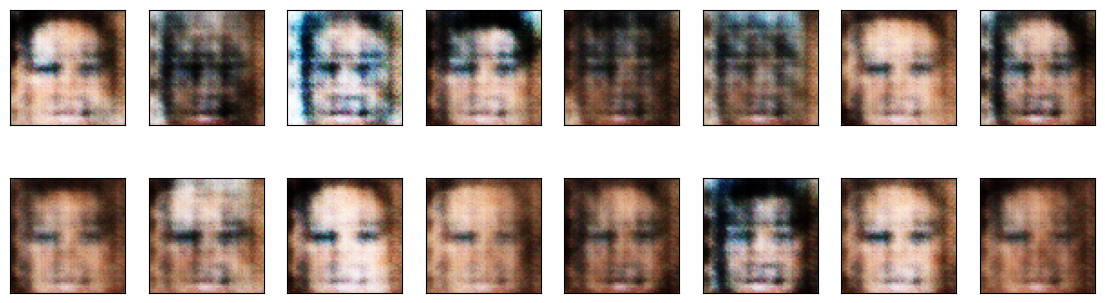

Starting Epoch [2/3]...


In [ ]:
from datetime import datetime
from torch.optim.lr_scheduler import StepLR

# Fixed latent vector for visualizing generator's progress
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).to(device)

losses = []

# Define the learning rate schedulers
d_scheduler = StepLR(d_optimizer, step_size=30, gamma=0.5)  # Reduce LR every 30 epochs
g_scheduler = StepLR(g_optimizer, step_size=30, gamma=0.5)

"""
GAN Training Loop Breakdown:

1. Epoch Loop:
   - Iterates for `n_epochs` total passes through dataset
   - Prints progress at start of each epoch

2. Batch Loop (per epoch):
   - Processes real images in batches from dataloader
   - Transfers batch to target device (GPU/CPU)

3. Discriminator Update:
   - 1x per batch using `discriminator_step()`
   - Learns to distinguish real vs generated images

4. Generator Update:
   - 2x per batch using `generator_step()`
   - Extra update helps balance G/D training
   - Learns to fool discriminator

5. Loss Tracking:
   - Stores (discriminator_loss, generator_loss) per batch
   - Prints epoch-end summary with timestamp

6. Visualization:
   - Generates sample images from fixed latent vector
   - Switches generator to eval mode temporarily

7. Learning Rate Scheduling:
   - Adjusts LR for both networks after each epoch
   - Helps fine-tune convergence

Key Implementation Notes:
- Batch norm behaves differently in train/eval modes
- Fixed latent vector allows progress monitoring
- Timestamps help track training duration
"""
for epoch in range(n_epochs):
    print(f"Starting Epoch [{epoch + 1}/{n_epochs}]...")  # Start of each epoch

    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        ####################################
        # Train the discriminator
        d_loss = discriminator_step(
            generator, discriminator, d_optimizer,
            batch_size, latent_dim, real_images, device
        )

        # Train the generator twice for better convergence
        g_loss = generator_step(
            generator, discriminator, g_optimizer,
            batch_size, latent_dim, device
        )
        g_loss = generator_step(
            generator, discriminator, g_optimizer,
            batch_size, latent_dim, device
        )
        ####################################

        # Append discriminator and generator losses for tracking
        d = d_loss['loss'].item()
        g = g_loss['loss'].item()
        losses.append((d, g))

        # Print loss details only at the end of the epoch
        if batch_i == len(dataloader) - 1:
            time = str(datetime.now()).split('.')[0]
            print(
                f'End of Epoch [{epoch + 1}/{n_epochs}]. {time} | Epoch [{epoch + 1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')

    # Display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

    # Step the learning rate schedulers after each epoch
    d_scheduler.step()
    g_scheduler.step()

print("Training complete.")


### Training losses

Plot the training losses for the generator and discriminator.

In [ ]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots(figsize=(16, 4))
losses = np.array(losses)

plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** The generated faces show reasonable structure but lack fine details and diversity, with noticeable artifacts and blurriness. The training graphs indicate instability in generator performance (high fluctuating loss) while the discriminator remains relatively stable. The model could be improved by increasing model capacity, implementing WGAN-GP loss with gradient penalty, using progressive growing architecture, and most importantly, training for more epochs with a more diverse dataset to address the current bias towards white celebrities.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.